# Evaluate model performance

In [1]:
# Load price data
import pandas as pd
prices = pd.read_csv('data/eurusd_minute.csv')['BidClose'].values

In [2]:
from src.dataset import EncodedForexData
import numpy as np
from tqdm import tqdm

from src.encoders import SimpleRasterizeEncoder, GasfEncoder
simple_dataset = EncodedForexData(prices, 64, encoder=SimpleRasterizeEncoder(), relative=False)
rel_simple_dataset = EncodedForexData(prices, 64, encoder=SimpleRasterizeEncoder(), relative=True)
gasf_dataset = EncodedForexData(prices, 64, encoder=GasfEncoder(), relative=False)

standardize = lambda x: (x-x.mean())/x.std()

simple_encoder = SimpleRasterizeEncoder()
gasf_encoder = GasfEncoder()

/home/jekabs/anaconda3/envs/ml_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
samples = [simple_encoder.decode(x) for x in tqdm(simple_dataset)]
simple_data = np.concatenate([standardize(np.diff(x)) for x in tqdm(samples)])
rel_samples = [simple_encoder.decode(x) for x in tqdm(rel_simple_dataset)]
rel_data = np.concatenate([standardize(x) for x in tqdm(rel_samples)])
gasf_samples = [gasf_encoder.decode(x) for x in tqdm(gasf_dataset)]
gasf_data = np.concatenate([standardize(np.diff(x)) for x in tqdm(gasf_samples)])
print(simple_data.shape, rel_data.shape, gasf_data.shape)

100%|██████████| 80690/80690 [00:03<00:00, 22451.00it/s]


(5083470,) (5164160,) (5083470,)


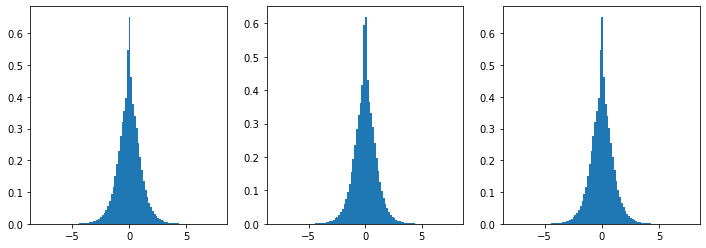

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.hist(simple_data, bins=100, density=True)
ax2.hist(rel_data, bins=100, density=True)
ax3.hist(gasf_data, bins=100, density=True)
plt.show()

In [5]:
from src.models import Generator
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Generator().to(device)
model.eval()

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (cnn): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

In [6]:
# Compare generated data to original data
import numpy as np

def sample_model(model, decoder, n):
    sample_batches = []
    with torch.no_grad():
        noise = torch.randn(n,100).to(device)
        for i in range(n//100):
            sample_batches.append(model(noise[i*100:(i+1)*100]))

    samples = []
    for batch in sample_batches:
        for mat in batch:
            samples.append(standardize(decoder(mat)))

    return np.stack(samples)

In [8]:
import matplotlib.pyplot as plt
from src.utils import plot_cdf
from scipy.stats import kstest

experiment = 'gasf4'
name = 'gasf_iter20'
data = simple_data

# decode = lambda x: simple_encoder.decode(x)
decode = lambda x: np.diff(simple_encoder.decode(x))

n = 1000

epoch_weights = [f'experiments/{experiment}/model/checkpoints/{i}/g.pt' for i in range(71)]

def get_ks(weights, model, decoder, n, data):
    model.load_state_dict(torch.load(weights))
    model_samples = sample_model(model, decode, n)
    model_data = model_samples.reshape(-1)
    ks = kstest(data, model_data)
    assert ks[1] < 0.05
    return ks.statistic


ks_vals = np.array([get_ks(w, model, decode, n, data) for w in tqdm(epoch_weights)])
np.save(f'results/{name}_ks_vals.npy', ks_vals)

100%|██████████| 71/71 [01:36<00:00,  1.36s/it]


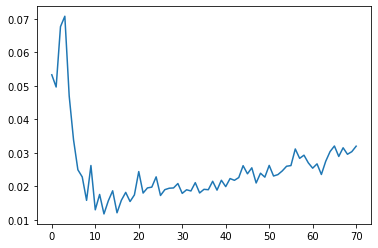

In [11]:
plt.plot(ks_vals)